### Автоматическое дифференцирование

In [1]:
import torch

In [2]:
x = torch.tensor([2.0], requires_grad=True)
y = torch.tensor([-4.0], requires_grad=True)
f = (x + y)**2 + 2*x*y
f.backward()
print(x.grad, x.data)
print(y.grad, y.data)
print(f)

tensor([-12.]) tensor([2.])
tensor([0.]) tensor([-4.])
tensor([-12.], grad_fn=<AddBackward0>)


### Реализация SGD на Pytorch

$$w = [w_0,w_1]^T$$
$$a(x) = w^T\cdot x = w_0\cdot 1 + w_1\cdot x_1$$
$$f(x) = 0.5\cdot x + 0.2\cdot sin(2x) - 3$$
$$Q(x) = \sum_{i=1}^{n}(a(x_i) - f(x_i))^2$$

In [3]:
import torch
import torch.optim as optim
from random import randint
import matplotlib.pyplot as plt

tensor([-2.7562,  0.3162], requires_grad=True)


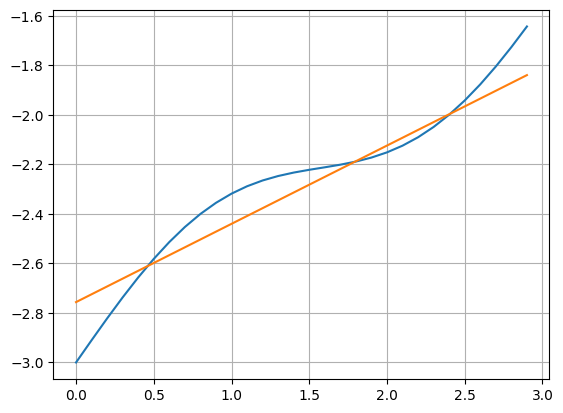

In [4]:
def model(X,w):
    return X @ w

N = 2 # количество весов
w = torch.FloatTensor(N).uniform_(-1e-5,1e-5) # формируем случайные значения из равномерного р.
w.requires_grad_(True) # чтобы вычислять производные для вектор w
x = torch.arange(0, 3, 0.1)

y_train = 0.5*x + 0.2*torch.sin(2*x) - 3
x_train = torch.tensor([[_x**_n for _n in range(N)] for _x in x])

total = len(x)
lr = torch.tensor([0.1, 0.01]) # шаги для w_0 и для w_1
# loss_func = torch.nn.MSELoss()
loss_func = torch.nn.L1Loss()
# optimizer = optim.SGD(params=[w], lr=0.01, momentum = 0.8, nesterov=True)
optimizer = optim.Adam(params=[w], lr=0.01)

for _ in range(1000): # 1k операций
    k = randint(0,total-1)
    y = model(x_train[k], w)
    loss = loss_func(y,y_train[k])

    loss.backward()
    # w.data = w.data - lr * w.grad
    # w.grad.zero_()
    optimizer.step()
    optimizer.zero_grad()

print(w)
predict = model(x_train, w)
plt.plot(x, y_train.numpy())
plt.plot(x, predict.data.numpy())
plt.grid()
plt.show()

$$w^{n} = w^{n-1} - \eta \nabla L(x_k)$$

###  Классы nn.Linear и nn.Module

In [5]:
import torch.nn as nn
import torch.nn.functional as F

In [6]:
def forward(inp, l1: nn.Linear, l2: nn.Linear):
    u1 = l1.forward(inp)
    s1 = F.tahn(u1)

    u2 = l2.forward(s1)
    s2 = F.tahn(u2)
    return s2

layer1 = nn.Linear(in_features=3, # in_features - кол-во входов без байеса
                   out_features=2) # на выходе 2 значения
layer2 = nn.Linear(in_features=2, out_features=1)

In [ ]:
print(layer1.weight) # веса инициализируются как [-1/sqrt(n),1/sqrt(n)] 
print(layer1.bias) # из равномерного распределения

Parameter containing:
tensor([[-0.2725,  0.2423,  0.3305],
        [ 0.1693, -0.2693, -0.4612]], requires_grad=True)
Parameter containing:
tensor([0.3773, 0.2203], requires_grad=True)


In [ ]:
class NetGirl(nn.Module):
    def __init__(self, input_dim, num_hidden, output_dim):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, num_hidden)
        self.layer2 = nn.Linear(num_hidden, output_dim)

    def forward(self, x):
        x = self.layer1(x)
        x = F.tanh(x)
        x = self.layer2(x)
        x = F.tanh(x)
        return x

In [9]:
model = NetGirl(3,2,1)
print(model)

NetGirl(
  (layer1): Linear(in_features=3, out_features=2, bias=True)
  (layer2): Linear(in_features=2, out_features=1, bias=True)
)


In [10]:
gen_p = model.parameters()
print(list(gen_p))

[Parameter containing:
tensor([[ 0.5038, -0.0337, -0.2202],
        [-0.4109,  0.5311,  0.3038]], requires_grad=True), Parameter containing:
tensor([-0.1245, -0.4566], requires_grad=True), Parameter containing:
tensor([[-0.6180, -0.4921]], requires_grad=True), Parameter containing:
tensor([-0.5880], requires_grad=True)]


In [11]:
# Обучаем модель
optimizer = optim.RMSprop(params=model.parameters(), lr = 0.01)
loss_func = torch.nn.MSELoss()

In [12]:
x_train  = torch.FloatTensor([(-1,-1,-1), (-1,-1,1), (-1,1,-1), (-1,1,1),
                             (1,-1,-1), (1,-1,1), (1,1,-1), (1,1,1) ])
y_train = torch.FloatTensor([-1,1,-1,1,-1,1,-1,-1])
total = len(y_train)

In [ ]:
# переводим сеть в режим обучения
model.train() 
# если в модели есть такие методы как Dropout или BatchNormalization, то сеть по-разному будет работать в режиме обучения и эксплуатации
for _ in range(1000):
    k = randint(0, total-1)
    y = model(x_train[k])
    y = y.squeeze()
    loss = loss_func(y,y_train[k])

    optimizer.zero_grad() # обнуляем все градиенты
    loss.backward() # алгоритм обратного распространения ошибки
    optimizer.step() # корректировка весов

In [ ]:
model.eval() # возвращаем в режим эксплуатации
# model.requires_grad_(False) # отключаем градиенты не через with

NetGirl(
  (layer1): Linear(in_features=3, out_features=2, bias=True)
  (layer2): Linear(in_features=2, out_features=1, bias=True)
)

In [ ]:
for x, d in zip(x_train, y_train):
    with torch.no_grad():
        y = model(x)
        print(f'Выходное значение НС: {y.data} => {d}')

Выходное значение НС: tensor([-0.9814]) => -1.0
Выходное значение НС: tensor([0.9977]) => 1.0
Выходное значение НС: tensor([-0.9996]) => -1.0
Выходное значение НС: tensor([0.9783]) => 1.0
Выходное значение НС: tensor([-0.9996]) => -1.0
Выходное значение НС: tensor([0.9785]) => 1.0
Выходное значение НС: tensor([-0.9998]) => -1.0
Выходное значение НС: tensor([-0.9710]) => -1.0


### Dataset и Dataloader

- Dataset - универсальное представление обучающих и тестовых данных 
- Dataloader - универсальный итератор для извлечения данных, например, в процессе обучения или тестирования

По возможности выборки должны быть сбалансированными и репрезентативными (применение аугментации в том числе);

***Dataset***

In [115]:
import torch.utils.data as data
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.v2 as tfs
from tqdm import tqdm 
import json
import os

class MyDataset(data.Dataset): # имя класса MyDataset может быть любым
    def __init__(self): # инициализация переменных объекта класса
        pass

    def __getitem__(self, item): # возвращение образа выборки по индексу item
        pass
    
    def __len(self): # возвращение размера выборки
        pass

In [54]:
fotmas = {"class_0": 0, "class_1": 1, "class_2": 2, "class_3": 3, "class_4": 4, "class_5": 5, "class_6": 6, "class_7": 7, "class_8": 8, "class_9": 9}
fotmas.items()

dict_items([('class_0', 0), ('class_1', 1), ('class_2', 2), ('class_3', 3), ('class_4', 4), ('class_5', 5), ('class_6', 6), ('class_7', 7), ('class_8', 8), ('class_9', 9)])

In [64]:
from PIL import Image
class DigitDataset(data.Dataset):
    def __init__(self, path, train=True, transform=None):
        self.path = os.path.join(path,"train" if train else "test")
        self.transform = transform

        with open(os.path.join(path, "format.json"), "r") as fp:
            self.format = json.load(fp)
        
        self.length = 0 # размер обучающей выборки
        self.files = [] # список файлов в зависимости от train=True
        self.targets = torch.eye(10) # единичная матрицы

        for _dir, _target in self.format.items():
            path = os.path.join(self.path, _dir)
            list_files = os.listdir(path)
            self.length += len(list_files)
            self.files.extend(map(lambda _x: (os.path.join(path, _x), _target), list_files))
    
    def __getitem__(self, item): # возвращает 1 образ из обучающей выборки
        path_file, target = self.files[item]
        t = self.targets[target]
        img = Image.open(path_file)

        if self.transform:
            img = self.transform(img).ravel().float() / 255.
            
        return img, t
    
    def __len__(self):
        return self.length 

In [65]:
to_tensor = tfs.ToImage()
d_train = DigitDataset("dataset", transform=to_tensor)
train_data = data.DataLoader(d_train, batch_size=32, shuffle=True)

## Классификация изображений цифр БД MNIST

- Для распознавания графических образов хорошо себя зарекомендовали сверточные нейронные сети, однако их будем рассматривать позже

In [105]:
class DigitNN(nn.Module):
    def __init__(self, input_dim, num_hidden, output_dim):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, num_hidden)
        self.layer2 = nn.Linear(num_hidden, output_dim)

    def forward(self, x):
        x = self.layer1(x)
        x = nn.functional.relu(x)
        x = self.layer2(x)
        return x

In [106]:
model = DigitNN(28 * 28, 32, 10)

In [107]:
to_tensor = tfs.ToImage()
d_train = DigitDataset("dataset", transform=to_tensor)
train_data = data.DataLoader(d_train, batch_size=32, shuffle=True)
print(len(d_train))

60000


In [108]:
optimizer = optim.Adam(params=model.parameters(), lr=0.01)
loss_function = nn.CrossEntropyLoss()

In [109]:
epochs = 2
model.train()

DigitNN(
  (layer1): Linear(in_features=784, out_features=32, bias=True)
  (layer2): Linear(in_features=32, out_features=10, bias=True)
)

In [116]:
for _e in range(epochs):
    loss_mean = 0 # среднее значение функции потерь (по эпохе)
    lm_count = 0 # текущее количество слагаемых 
    
    train_tqdm = tqdm(train_data, leave=True) # leave=True - оставляет предыдущий прогрессбар на экране
    for x_train, y_train in train_tqdm:
        predict = model(x_train)    
        loss = loss_function(predict, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        lm_count += 1
        loss_mean = 1 / lm_count * loss.item() + (1- 1/lm_count)*loss_mean
        train_tqdm.set_description(f'Epochs {_e+1}, loss mean = {loss_mean:.3f}')

Epochs 2, loss mean = 0.149: 100%|██████████| 1875/1875 [00:13<00:00, 134.48it/s]


In [80]:
# Тестирование обученной НС
model.eval()

DigitNN(
  (layer1): Linear(in_features=784, out_features=32, bias=True)
  (layer2): Linear(in_features=32, out_features=10, bias=True)
)

In [96]:
d_test = DigitDataset("dataset", train=False, transform=to_tensor)
test_data = data.DataLoader(d_test, batch_size=500, shuffle=False)
Q = 0
for x_test, y_test in test_data:
    with torch.no_grad():
        p = model(x_test)
        p = torch.argmax(p, dim=1)
        y = torch.argmax(y_test, dim=1)
        Q += torch.sum(p == y).item()

In [99]:
Q /= len(d_test)
print(Q)

0.9432


## Класс ImageFolder

In [117]:
from torchvision.datasets import ImageFolder

In [118]:
to_tensor = tfs.ToImage() # PIL to Tensor
d_train = ImageFolder("dataset/train", transform=to_tensor)
train_data = data.DataLoader(d_train, batch_size=32, shuffle=True)

In [119]:
x,y = d_train[0]

In [ ]:
x.size() # тут используются 3 цвета канала RGB
# исходное изображение имеет 1 канал и представлена в градции серого
# но нам это не нужно

torch.Size([3, 28, 28])

In [131]:
transforms = tfs.Compose([tfs.ToImage(), tfs.Grayscale(),
                          tfs.ToDtype(torch.float32, scale=True),
                          tfs.Lambda(lambda _img: _img.ravel())]) # PIL to Tensor and RGB to Gray
d_train = ImageFolder("dataset/train", transform=transforms)
train_data = data.DataLoader(d_train, batch_size=32, shuffle=True)

**Train model**

In [140]:
epochs = 2
model.train()

DigitNN(
  (layer1): Linear(in_features=784, out_features=32, bias=True)
  (layer2): Linear(in_features=32, out_features=10, bias=True)
)

In [141]:
for _e in range(epochs):
    loss_mean = 0 # среднее значение функции потерь (по эпохе)
    lm_count = 0 # текущее количество слагаемых 
    
    train_tqdm = tqdm(train_data, leave=True) # leave=True - оставляет предыдущий прогрессбар на экране
    for x_train, y_train in train_tqdm:
        predict = model(x_train)    
        loss = loss_function(predict, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        lm_count += 1
        loss_mean = 1 / lm_count * loss.item() + (1- 1/lm_count)*loss_mean
        train_tqdm.set_description(f'Epochs {_e+1}, loss mean = {loss_mean:.3f}')

Epochs 2, loss mean = 0.134: 100%|██████████| 1875/1875 [00:16<00:00, 113.85it/s]


**Test model**

Tестирование обученной НС

In [142]:
model.eval()

DigitNN(
  (layer1): Linear(in_features=784, out_features=32, bias=True)
  (layer2): Linear(in_features=32, out_features=10, bias=True)
)

In [145]:
d_test = ImageFolder("dataset/test", transform=transforms)
test_data = data.DataLoader(d_test, batch_size=500, shuffle=False)
Q = 0
for x_test, y_test in test_data:
    with torch.no_grad():
        p = model(x_test)
        p = torch.argmax(p, dim=1)
        Q += torch.sum(p == y).item()

## Сохранение и загрузка моделей. Функции torch.save() и torch.load()

In [ ]:
model = DigitNN(28*28, 32, 10)
st = model.state_dict() # словарь состояний

In [148]:
torch.save(st,'torch_models/model_dnn.tar')

In [151]:
# weights_only означает, что выполняется загрузка приметивных типов данных
state_dict = torch.load('torch_models/model_dnn.tar', weights_only=True)

In [152]:
model.load_state_dict(state_dict)

<All keys matched successfully>

In [160]:
best_loss = 1e10 # заведомо высокое значение

for _e in range(epochs):
    loss_mean = 0 # среднее значение функции потерь (по эпохе)
    lm_count = 0 # текущее количество слагаемых 
    
    train_tqdm = tqdm(train_data, leave=True) # leave=True - оставляет предыдущий прогрессбар на экране
    for x_train, y_train in train_tqdm:
        predict = model(x_train)    
        loss = loss_function(predict, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        lm_count += 1
        loss_mean = 1 / lm_count * loss.item() + (1- 1/lm_count)*loss_mean
        train_tqdm.set_description(f'Epochs {_e+1}, loss mean = {loss_mean:.3f}')

    if best_loss > loss_mean * 1.1:
        best_loss = loss_mean
        st = model.state_dict()
        torch.save(st,f"torch_models/model_dnn_{_e}.tar")

Epochs 2, loss mean = 2.317: 100%|██████████| 1875/1875 [00:15<00:00, 117.39it/s]


In [165]:
st = torch.load("torch_models/model_dnn_1.tar", weights_only=True)
model.load_state_dict(st)

<All keys matched successfully>

Можно сохранять не только состояние модели, но и состояние оптимизатора и трансформаций

In [166]:
model_state_dict = {
    'tfs' : transforms.state_dict(),
    'opt' : optimizer.state_dict(),
    'model' : model.state_dict(),
}

In [167]:
best_loss = 1e10 # заведомо высокое значение

for _e in range(epochs):
    loss_mean = 0 # среднее значение функции потерь (по эпохе)
    lm_count = 0 # текущее количество слагаемых 
    
    train_tqdm = tqdm(train_data, leave=True) # leave=True - оставляет предыдущий прогрессбар на экране
    for x_train, y_train in train_tqdm:
        predict = model(x_train)    
        loss = loss_function(predict, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        lm_count += 1
        loss_mean = 1 / lm_count * loss.item() + (1- 1/lm_count)*loss_mean
        train_tqdm.set_description(f'Epochs {_e+1}, loss mean = {loss_mean:.3f}')

    if best_loss > loss_mean * 1.1:
        best_loss = loss_mean
        model_state_dict['model'] = model.state_dict()
        torch.save(model_state_dict,f"torch_models/model_dnn_new_{_e}.tar")

Epochs 2, loss mean = 2.317: 100%|██████████| 1875/1875 [00:15<00:00, 118.31it/s]


## Переобучение (Overfitting)

In [195]:
import torchvision
dataset_mnist = torchvision.datasets.MNIST(r'C:\datasets\mnist', download=True, train=True,transform=transforms)
d_train, d_val = data.random_split(dataset_mnist, [0.7, 0.3])
train_data = data.DataLoader(d_train, batch_size=32, shuffle=True)
train_data_val = data.DataLoader(d_val, batch_size=32,shuffle=False)

In [196]:
optimizer = optim.Adam(params=model.parameters(), lr=0.01)
loss_function = nn.CrossEntropyLoss()
epochs = 20

In [197]:
epochs = 20
best_loss = 1e10 # заведомо высокое значение

loss_lst_val = [] # список значений потерь при валидации
loss_lst = [] # список значений потерь при обучении

for _e in range(epochs):
    model.train() # в начале каждой эпохи переводим модель в режим обучения
    loss_mean = 0 # среднее значение функции потерь (по эпохе)
    lm_count = 0 # текущее количество слагаемых 
    
    train_tqdm = tqdm(train_data, leave=False) # leave=True - оставляет предыдущий прогрессбар на экране
    for x_train, y_train in train_tqdm:
        predict = model(x_train)    
        loss = loss_function(predict, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        lm_count += 1
        loss_mean = 1 / lm_count * loss.item() + (1- 1/lm_count)*loss_mean
        train_tqdm.set_description(f'Epochs {_e+1}, loss mean = {loss_mean:.3f}')
    
    # Валидация модели
    model.eval()
    Q_val = 0
    count_val = 0

    for x_val, y_val in train_data_val:
        with torch.no_grad():
            p = model(x_val)
            loss = loss_function(p, y_val)
            Q_val += loss.item( )
            count_val += 1
    Q_val /= count_val

    loss_lst.append(loss_mean)
    loss_lst_val.append(Q_val)

    # print(f" | loss_mean = {loss_mean: .3f}, Q_val={Q_val:.3f}")

In [198]:
d_test = ImageFolder("dataset/test", transform=transforms)
test_data = data.DataLoader(d_test, batch_size=500, shuffle=False)
# тестирование обученной НС
model.eval()
Q = 0

for x_test, y_test in test_data:
    with torch.no_grad():
        p = model(x_test)
        p = torch.argmax(p, dim=1)
        Q += torch.sum(p == y_test).item()

Q /= len(d_test)
print(Q)

0.9482


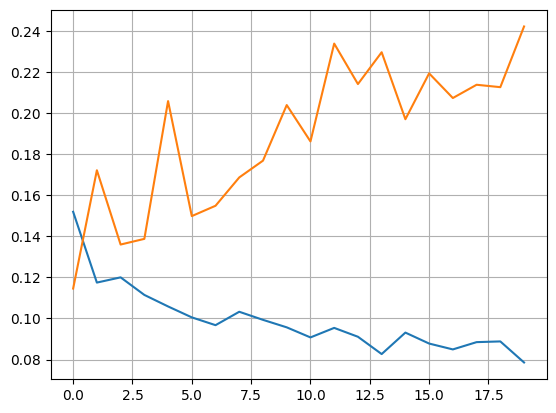

In [199]:
import matplotlib.pyplot as plt
# Вывод графиков
plt.plot(loss_lst)
plt.plot(loss_lst_val)
plt.grid()
plt.show()

##  L2-регуляризатор

l1-регуляризация не используется, потому что она склонна к занулению весов в нейронной сети, что может негативно сказаться на ее работе

In [200]:
optimizer = optim.Adam(params=model.parameters(), lr=0.01, weight_decay = 0.001)
loss_function = nn.CrossEntropyLoss()
epochs = 20

In [201]:
epochs = 20
best_loss = 1e10 # заведомо высокое значение

loss_lst_val = [] # список значений потерь при валидации
loss_lst = [] # список значений потерь при обучении

for _e in range(epochs):
    model.train() # в начале каждой эпохи переводим модель в режим обучения
    loss_mean = 0 # среднее значение функции потерь (по эпохе)
    lm_count = 0 # текущее количество слагаемых 
    
    train_tqdm = tqdm(train_data, leave=False) # leave=True - оставляет предыдущий прогрессбар на экране
    for x_train, y_train in train_tqdm:
        predict = model(x_train)    
        loss = loss_function(predict, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        lm_count += 1
        loss_mean = 1 / lm_count * loss.item() + (1- 1/lm_count)*loss_mean
        train_tqdm.set_description(f'Epochs {_e+1}, loss mean = {loss_mean:.3f}')
    
    # Валидация модели
    model.eval()
    Q_val = 0
    count_val = 0

    for x_val, y_val in train_data_val:
        with torch.no_grad():
            p = model(x_val)
            loss = loss_function(p, y_val)
            Q_val += loss.item( )
            count_val += 1
    Q_val /= count_val

    loss_lst.append(loss_mean)
    loss_lst_val.append(Q_val)

    # print(f" | loss_mean = {loss_mean: .3f}, Q_val={Q_val:.3f}")

In [202]:
model.eval()
Q = 0

for x_test, y_test in test_data:
    with torch.no_grad():
        p = model(x_test)
        p = torch.argmax(p, dim=1)
        Q += torch.sum(p == y_test).item()

Q /= len(d_test)
print(Q)

0.9261


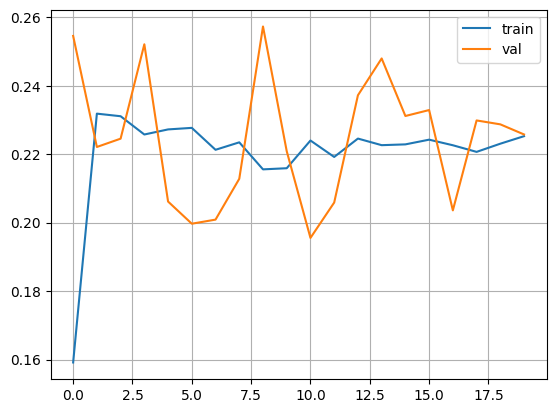

In [205]:
# Вывод графиков
plt.plot(loss_lst)
plt.plot(loss_lst_val)
plt.grid()
plt.legend(['train','val'])
plt.show()

## Dropout

- Корень проблемы переобучения кроется в излишней специализации каждого нейрона. 
- Цель dropout - сделать из нейронов специалистов более широкого профиля
- На каждой итерации изменения весовых коэффициентов часть нейронов с заданной вероятностью p мы выключаем.
- Важно использовать model.train() и model.evaluate()

Когда в процессе обучения нейроны отключаются, сумма на входах будет другой, а когда будем эту нейросеть использовать в продакшине, все нейроны, предполагается, будут включены. То есть происходит искажение входного сигнала
$$z = w_1\cdot u_1 + w_2\cdot u_2 + w_3\cdot u_3 + w_4\cdot u_4 + w_5\cdot u_5$$
$$z_q = w_3\cdot u_3 + w_4\cdot u_4 + w_5\cdot u_5$$

Поэтому сигнал $z_q$, который соответствует части отброшенных нейронов нужно скорректировать так, чтобы он в среднем по величине был эквивалентен $z$, когда все нейроны включены.

$z_q < z$, n - число нейронов

Среднее число выключенныхх нейронов можно определить как математическое ожидание:

$E(X) = \sum_{i=1}^n x_i\cdot p_i$

$p_i = p$ - вероятность выключения нейрона (она у всех одна), а $x_i=1$ всегда

$E(X) = \sum_{i=1}^n p = np$

Тогда среднее число включенных нейронов:

$n-np = n(1-p) = nq$, $q$ - вероятность того, что нейрон включен (обратная величина)

$\frac{z_q}{z} \sim \frac{nq}{n}=q$

Тогда, чтобы масштаб $z_q$ был сопоставим в среднем с $z$, мы должны $z_q \cdot \frac{1}{q}$


Параметр $p$ подбирается из опыта исследователя и здравого смысла. Можно начинать с p=0.5

- nn.Dropout() - для полносвязных слоев (nn.Linear);
- nn.Dropout1d() - для одномерных сверточных нейронных слоев (nn.Conv1d)
- nn.Dropout1d() - для двумерных сверточных нейронных слоев (nn.Conv2d)

In [207]:
class DigitNN(nn.Module):
    def __init__(self, input_dim, num_hidden, output_dim):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, num_hidden)
        self.layer2 = nn.Linear(num_hidden, output_dim)
        self.dropout_1 = nn.Dropout(0.3) # 0.3 - вероятность отключения нейрона

    def forward(self, x):
        x = self.layer1(x)
        x = nn.functional.relu(x)
        x = self.dropout_1(x) # обычно после ф-ии активации прописывается dropout
        x = self.layer2(x)
        return x

In [208]:
model = DigitNN(28 * 28, 128, 10)

In [209]:
optimizer = optim.Adam(params=model.parameters(), lr=0.01) #  weight_decay = 0.001
loss_function = nn.CrossEntropyLoss()
epochs = 20

In [210]:
epochs = 20
best_loss = 1e10 # заведомо высокое значение

loss_lst_val = [] # список значений потерь при валидации
loss_lst = [] # список значений потерь при обучении

for _e in range(epochs):
    model.train() # в начале каждой эпохи переводим модель в режим обучения
    loss_mean = 0 # среднее значение функции потерь (по эпохе)
    lm_count = 0 # текущее количество слагаемых 
    
    train_tqdm = tqdm(train_data, leave=False) # leave=True - оставляет предыдущий прогрессбар на экране
    for x_train, y_train in train_tqdm:
        predict = model(x_train)    
        loss = loss_function(predict, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        lm_count += 1
        loss_mean = 1 / lm_count * loss.item() + (1- 1/lm_count)*loss_mean
        train_tqdm.set_description(f'Epochs {_e+1}, loss mean = {loss_mean:.3f}')
    
    # Валидация модели
    model.eval()
    Q_val = 0
    count_val = 0

    for x_val, y_val in train_data_val:
        with torch.no_grad():
            p = model(x_val)
            loss = loss_function(p, y_val)
            Q_val += loss.item( )
            count_val += 1
    Q_val /= count_val

    loss_lst.append(loss_mean)
    loss_lst_val.append(Q_val)

    # print(f" | loss_mean = {loss_mean: .3f}, Q_val={Q_val:.3f}")

In [212]:
model.eval()
Q = 0

for x_test, y_test in test_data:
    with torch.no_grad():
        p = model(x_test)
        p = torch.argmax(p, dim=1)
        Q += torch.sum(p == y_test).item()

Q /= len(d_test)
print(Q)

0.9642


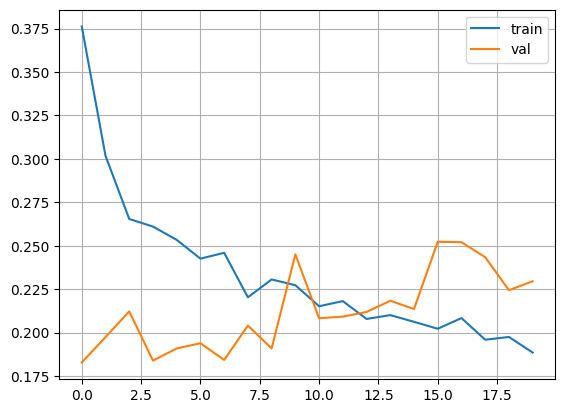

In [211]:
# Вывод графиков
plt.plot(loss_lst)
plt.plot(loss_lst_val)
plt.grid()
plt.legend(['train','val'])
plt.show()

## Batch Normalization

Нормализация в пределах батчей:

$$\hat \mu = \frac{1}{batch} \cdot  \sum_{i=1}^{batch} x_i$$
$$\hat \sigma = \frac{1}{batch} \cdot \sum_{i=1}^{batch} (x_i - \hat \mu )^2$$

$$\Longrightarrow \hat x_i = \frac{x_i - \hat \mu}{\sqrt{\hat \sigma^2 + \epsilon}}, i = 1,2,... ,batch$$

$\epsilon$ - небольшая положительная добавка, чтобы избежать деления на ноль

Значит в пределах батча после нормировки у нас будет нулевое среднее и единичную дисперсия

Еще вводятся обучаемые параметры $\gamma$ (масштаб) и $\beta$ (сдвиг) для восстановления выразительности сети:

$$y_i^{k} = \gamma^{k} \cdot \hat x_i^{k} + \beta^{k}$$

In [213]:
class DigitNN(nn.Module):
    def __init__(self, input_dim, num_hidden, output_dim):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, num_hidden)
        self.layer2 = nn.Linear(num_hidden, output_dim)
        self.bn_1 = nn.BatchNorm1d(num_hidden) 

    def forward(self, x):
        x = self.layer1(x)
        x = nn.functional.relu(x)
        x = self.bn_1(x) 
        x = self.layer2(x)
        return x

In [214]:
model = DigitNN(28 * 28, 128, 10)

In [215]:
optimizer = optim.Adam(params=model.parameters(), lr=0.01) #  weight_decay = 0.001
loss_function = nn.CrossEntropyLoss()
epochs = 20

In [216]:
epochs = 20
best_loss = 1e10 # заведомо высокое значение

loss_lst_val = [] # список значений потерь при валидации
loss_lst = [] # список значений потерь при обучении

for _e in range(epochs):
    model.train() # в начале каждой эпохи переводим модель в режим обучения
    loss_mean = 0 # среднее значение функции потерь (по эпохе)
    lm_count = 0 # текущее количество слагаемых 
    
    train_tqdm = tqdm(train_data, leave=False) # leave=True - оставляет предыдущий прогрессбар на экране
    for x_train, y_train in train_tqdm:
        predict = model(x_train)    
        loss = loss_function(predict, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        lm_count += 1
        loss_mean = 1 / lm_count * loss.item() + (1- 1/lm_count)*loss_mean
        train_tqdm.set_description(f'Epochs {_e+1}, loss mean = {loss_mean:.3f}')
    
    # Валидация модели
    model.eval()
    Q_val = 0
    count_val = 0

    for x_val, y_val in train_data_val:
        with torch.no_grad():
            p = model(x_val)
            loss = loss_function(p, y_val)
            Q_val += loss.item( )
            count_val += 1
    Q_val /= count_val

    loss_lst.append(loss_mean)
    loss_lst_val.append(Q_val)

    # print(f" | loss_mean = {loss_mean: .3f}, Q_val={Q_val:.3f}")

In [217]:
model.eval()
Q = 0

for x_test, y_test in test_data:
    with torch.no_grad():
        p = model(x_test)
        p = torch.argmax(p, dim=1)
        Q += torch.sum(p == y_test).item()

Q /= len(d_test)
print(Q)

0.9741


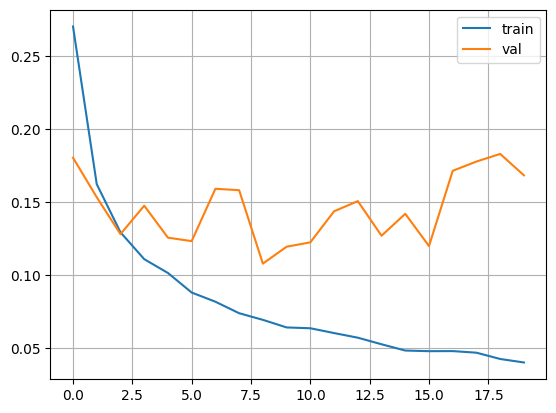

In [218]:
# Вывод графиков
plt.plot(loss_lst)
plt.plot(loss_lst_val)
plt.grid()
plt.legend(['train','val'])
plt.show()

## Sequential(), ModuleList(), ModuleDict()

In [223]:
model = nn.Sequential()
model.add_module('layer_1', nn.Linear(28 * 28, 32))
model.add_module('relu', nn.ReLU())
model.add_module('layer_2', nn.Linear(32,10))

In [224]:
print(model)

Sequential(
  (layer_1): Linear(in_features=784, out_features=32, bias=True)
  (relu): ReLU()
  (layer_2): Linear(in_features=32, out_features=10, bias=True)
)


С помощью класса ModuleList() мы можем генерировать слои и их регистрировать

In [245]:
class ModelNN(nn.Module):
    def __init__(self, input_dim, output_dim, n_layers=3):
        super().__init__()
        self.layers = nn.ModuleList()
        for n in range(1, n_layers+1):
            self.layers.add_module(f'layer_{n}', nn.Linear(input_dim // n, input_dim // (n+1)) )
            
        self.layer_out = nn.Linear(input_dim // (n_layers+1), output_dim)
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
            x = nn.functional.tanh(x)
        
        x = self.layer_out(x)

In [246]:
model = ModelNN(28 * 28, 10)
print(model)

ModelNN(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=392, bias=True)
    (1): Linear(in_features=392, out_features=261, bias=True)
    (2): Linear(in_features=261, out_features=196, bias=True)
  )
  (layer_out): Linear(in_features=196, out_features=10, bias=True)
)


In [248]:
model.layers.layer_1

Linear(in_features=784, out_features=392, bias=True)

ModuleDict() регистрирует отдельные слои, но хранит их в виде словаря

In [249]:
class ModelNN(nn.Module):
    def __init__(self, input_dim, output_dim, n_layers=3, act_type=None):
        super().__init__()
        self.layers = nn.ModuleList()
        self.act_type = act_type
        for n in range(1, n_layers+1):
            self.layers.add_module(f'layer_{n}', nn.Linear(input_dim // n, input_dim // (n+1)) )
            
        self.layer_out = nn.Linear(input_dim // (n_layers+1), output_dim)
        self.act_lst = nn.ModuleDict({
            'relu': nn.ReLU(),
            'lk_relu': nn.LeakyReLU(),
        })

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
            if self.act_type and self.act_type in self.act_lst:
                x = self.act_lst[self.act_type](x)

        x = self.layer_out(x)

In [250]:
model = ModelNN(28 * 28, 10, act_type='relu')
print(model)

ModelNN(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=392, bias=True)
    (1): Linear(in_features=392, out_features=261, bias=True)
    (2): Linear(in_features=261, out_features=196, bias=True)
  )
  (layer_out): Linear(in_features=196, out_features=10, bias=True)
  (act_lst): ModuleDict(
    (relu): ReLU()
    (lk_relu): LeakyReLU(negative_slope=0.01)
  )
)
